# Model Selection

In [1]:
goog_drive=False

if goog_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    goog_dir = '/content/drive/My Drive/lending_club_project/'
else:
    goog_dir = ''

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from utils import chunk_loader

from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb

%matplotlib inline

In [3]:
#directory to save files
save_path = os.path.join(goog_dir, 'models')

# 1.0  Download the Data

In [5]:
#get directory
df_train_path = os.path.join(goog_dir, 'data','df_train_scaled.csv')
df_test_path = os.path.join(goog_dir,'data','df_test_scaled.csv')

#download in chunks
df_train = pd.read_csv(df_train_path, index_col=0, compression='zip')
df_test = pd.read_csv(df_test_path, index_col=0, compression='zip')

/Users/nadimkawwa/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
df_train.shape

(1292073, 43)

In [7]:
df_test.shape

(11534, 43)

In [8]:
target_col = 'loan_status'

#feature space
X_train = df_train.drop(columns=[target_col])
X_test = df_test.drop(columns=[target_col])

#target variable
y_train = df_train[target_col]
y_test = df_test[target_col]


# 2.0 Defining Our Metrics
The dataset is heaviliy imbalanced in favor of the positive class (pays back loan). We will take into account:
- Precision
- Recall
- F1 Score
- AUC

In [9]:
#ROC dict for TPR and FPR values
roc_dict = {}

#precision recall curve
prc_dict = {}

In [10]:
def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for ROC metrics
    """
    
    fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    
    clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds}
    
    dict_modify[name] = clf_roc_dict
    


In [11]:
def modify_prc_dict(clf, y_test, X_test, name ,dict_modify):
    """
    modifies a dictionary in place and adds keys for precision recall metrics
    """
    
    precision, recall, thresholds = precision_recall_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
    
    clf_prc_dict = {'precision':precision, 'recall': recall, 'thresholds': thresholds}
    
    dict_modify[name] = clf_prc_dict

# 3.0 Fit & Score

In [12]:
def fit_score_clf(clf, X_train, y_train, X_test, y_test, name='clf'):
    """
    fits a classifer from sklearn and returns a dataframe
    clf(sklearn): classifier
    X_train(numpy): train features
    y_train(numpy): predictions row vector
    X_test(numpy): test features
    y_test(numpy): ground truth row vector
    name(string): name of classifier
    
    """
    #fit to train data
    clf.fit(X_train, y_train)
    #make predictions
    y_pred = clf.predict(X_test)
    #make dataframe from report
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    #add clf name as column
    clf_report['clf'] = name
    
    return clf_report

## 3.1 Naive Bayes
Worth mentioning but not used since in our scaling of the data produces negative values. Naive Bayes does not accept negative values, for reference see article below:

https://stats.stackexchange.com/questions/169400/naive-bayes-questions-continus-data-negative-data-and-multinomialnb-in-scikit


## 3.2 Logistic Regression

In [13]:
#instantiate with default params
lr  = LogisticRegression(penalty='l2',
                         C=1.0,
                         solver = 'lbfgs',
                         max_iter=400,
                         n_jobs=-1)

lr_report = fit_score_clf(lr, X_train, y_train, X_test, y_test, name='lr')
lr_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.098988,0.963885,0.930553,0.531436,0.917093,lr
precision,0.166038,0.948531,0.930553,0.557285,0.906198,lr
recall,0.070513,0.979743,0.930553,0.525128,0.930553,lr
support,624.000000,10910.000000,0.930553,11534.000000,11534.000000,lr


In [14]:
#metrics for lr
modify_roc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression', 
                dict_modify=roc_dict)

In [15]:
modify_prc_dict(clf=lr,
                y_test=y_test,
                X_test=X_test,
                name='Logistic Regression',
                dict_modify=prc_dict)

## 3.3 Gradient Boosted Tree

In [16]:
gbtree = GradientBoostingClassifier(learning_rate=0.1,
                                    n_estimators = 100)

gbtree_report = fit_score_clf(gbtree, X_train, y_train, X_test, y_test, name='gbtree')
gbtree_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.083832,0.965592,0.933674,0.524712,0.917888,gbtree
precision,0.165877,0.947982,0.933674,0.556929,0.905669,gbtree
recall,0.056090,0.983868,0.933674,0.519979,0.933674,gbtree
support,624.000000,10910.000000,0.933674,11534.000000,11534.000000,gbtree


In [17]:
#metrics for gbtree
modify_roc_dict(gbtree, y_test, X_test, name='GBTree',dict_modify=roc_dict)

In [18]:
modify_prc_dict(clf=gbtree,
                y_test=y_test,
                X_test=X_test,
                name='GBTree',
                dict_modify=prc_dict)

## 3.4 KNN

In [19]:
knn = KNeighborsClassifier(n_neighbors =5, n_jobs=-1)

knn_report = fit_score_clf(knn, X_train, y_train, X_test, y_test, name='KNN')
knn_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.116468,0.934283,0.877666,0.525376,0.890039,KNN
precision,0.095581,0.949721,0.877666,0.522651,0.903511,KNN
recall,0.149038,0.919340,0.877666,0.534189,0.877666,KNN
support,624.000000,10910.000000,0.877666,11534.000000,11534.000000,KNN


In [20]:
#metrics for knn
modify_roc_dict(knn, y_test, X_test, name='KNN',dict_modify=roc_dict)

In [21]:
modify_prc_dict(clf=knn,
                y_test=y_test,
                X_test=X_test,
                name='knn',
                dict_modify=prc_dict)

## 3.5 SVM

In [22]:
#put hard limit on iterations to save time in exploration phase
svc = SVC(C=1.0, kernel='rbf',
          gamma='auto', 
          probability=True,
          max_iter=400)

svc_report = fit_score_clf(svc, X_train, y_train, X_test, y_test, name='svc')
svc_report.head()

/Users/nadimkawwa/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.101986,0.102453,0.10222,0.102219,0.102428,svc
precision,0.053910,0.942584,0.10222,0.498247,0.894506,svc
recall,0.942308,0.054170,0.10222,0.498239,0.102220,svc
support,624.000000,10910.000000,0.10222,11534.000000,11534.000000,svc


In [23]:
#metrics for svc
modify_roc_dict(svc, y_test, X_test, name='SVC',dict_modify=roc_dict)

In [24]:
modify_prc_dict(clf=svc,
                y_test=y_test,
                X_test=X_test,
                name='SVC',
                dict_modify=prc_dict)

## 3.6 Random Forest

In [25]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

rf_report = fit_score_clf(rf, X_train, y_train, X_test, y_test, name='rf')
rf_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.109989,0.964242,0.931247,0.537116,0.918026,rf
precision,0.183521,0.948966,0.931247,0.566243,0.907555,rf
recall,0.078526,0.980018,0.931247,0.529272,0.931247,rf
support,624.000000,10910.000000,0.931247,11534.000000,11534.000000,rf


In [26]:
#metrics for random forest
modify_roc_dict(rf, y_test, X_test, name='RandomForest',dict_modify=roc_dict)

In [27]:
modify_prc_dict(clf=rf,
                y_test=y_test,
                X_test=X_test,
                name='RandomForest',
                dict_modify=prc_dict)

## 3.7 XGBoost

In [28]:
xgb_clf = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)

xgb_report = fit_score_clf(xgb_clf, X_train, y_train, X_test, y_test, name='xgb')
xgb_report.head()

,0,1,accuracy,macro avg,weighted avg,clf
f1-score,0.100559,0.963695,0.930206,0.532127,0.916998,xgb
precision,0.166052,0.948593,0.930206,0.557322,0.906257,xgb
recall,0.072115,0.979285,0.930206,0.525700,0.930206,xgb
support,624.000000,10910.000000,0.930206,11534.000000,11534.000000,xgb


In [29]:
#metrics for svc
modify_roc_dict(xgb_clf, y_test, X_test, name='XGBoost',dict_modify=roc_dict)

In [30]:
modify_prc_dict(clf=xgb_clf,
                y_test=y_test,
                X_test=X_test,
                name='XGBoost',
                dict_modify=prc_dict)

# 4.0 Comparing Metrics
After training some classifiers with default paramters, we can get a first impression of performance. With the ROC metric, the best model is closest to the "North West" corver of the axes, where as for the PRC the best location is "North East".

We will show the y=x line in the ROC plot in order to provide a baseline. Any classifer at this line makes completely random predictions, a classifer below it makes worse predictions than a random guess. Should this be the case, it is possible that our features were not approriately set up for that classifier or that the initial default parmaeters were very poorly choosen.

In [31]:
#see keys we have
roc_dict.keys()

dict_keys(['Logistic Regression', 'GBTree', 'KNN', 'SVC', 'RandomForest', 'XGBoost'])

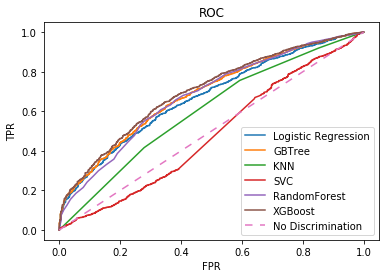

In [32]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()
plt.savefig(os.path.join(goog_dir, 'plots/roc_curve_all_models.png'))
plt.show()

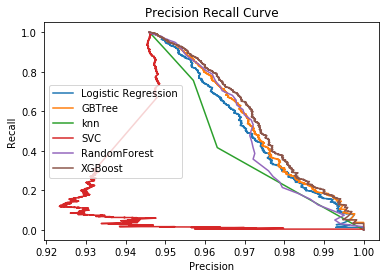

In [33]:
for key in prc_dict:
    clf = prc_dict[key]
    plt.plot(clf['precision'], clf['recall'], label=key)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision Recall Curve")
plt.legend()
plt.savefig(os.path.join(goog_dir, 'plots/prc_curve_all_models.png'))

plt.show()

# 5.0 Picking a Model
Looking at the overall performance, XGBoost seems to be the most viable option. In the next notebook we will iterate on the parameters to finetune performance.

In [34]:
#define location to save trained model
save_model_dir = os.path.join(save_path, 'xgb_default_params.pickle')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(xgb_clf,
                handle,
                protocol=pickle.HIGHEST_PROTOCOL)

Saving model at: models/xgb_default_params.pickle
